# Few Shot Learning Tutorial

#### This tutorial was prepared by Yuli Slavutsky as part of the Few-Shot leaning workshop for the Israeli Statistical Association.
#### Contact: yuli.slavutsky@mail.huji.ac.il
#### Git: https://github.com/YuliSl

All notation in this notebook follows the tutorial slides. For convinience, some of the relevant functions and definitions are provided here. <br>

This tutorial is implemented in tensorflow. Since some participants may not be familiar with the syntax, all the needed tensorflow functions are provided. Through the tutorial there are also a few comments explaining basic commands you may need to experiment with the provided code.



In [ ]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

import random

The following cell prints the versions of the main libraries used in this tutorial. 
Please ensure the libraries are loaded in the versions detailed in the following comment. If that is not the case, you can install the specific versions using a pip command in a new cell. For example:

```
! pip install tensorflow==2.9.2 
```



In [ ]:
print("tensorflow version: {}, tensorflow_addons version: {}, numpy version: {}".format(tf.__version__, tfa.__version__, np.__version__)) 
# tensorflow version: 2.9.2, tensorflow_addons version: 0.18.0, numpy version: 1.21.6

tensorflow version: 2.9.2, tensorflow_addons version: 0.18.0, numpy version: 1.21.6


In [ ]:
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

## Loss functions <br>

We start with the cross-entropy loss which is commonly used for standard classification tasks (that is with large amounts of labeled examples from each class).  <br>
$\ell(x_i, y_i)=-\sum_{k=1}^K -y_i^{(m)} \log h(x_i)$   
$L_T = \sum_i \ell(x_i, y_i)$ <br>
where $K$ the number of classes, $y_i$ is a one-hot label vactor (of length $K$, equals 1 at the component corresponding to the correct class, and 0 otherwise), and h(x_i) is a vector of the scores the classifier assigns for $x_i$ to belong to each class. <br>
We will use it for comparison purposes.

In [ ]:
def softamx_loss(X_hat, Y):
  return tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=X_hat)

Sometimes we will need to flatten Y to a vector $Y \in \mathbb{R}^{N}$ rather than a a matrix with N rows and column $Y \in \mathbb{R}^{N \times 1}$. <br>
We can do this by the following command: 

```
tf.reshape(Y, -1)
```

or


```
tf.reshape(Y, [-1,1])
```
to convert a vector into a matrix. <br>

In [ ]:
def binary_to_onehot(Y):
  Y_flat = tf.reshape(Y, -1)
  onehot = tf.stack([Y_flat, 1-Y_flat], axis=1)
  return onehot

Most deep learning libraries (including tensorflow) include built in functions for the few-shot loss functions we learned. <br>
The same is true for the learning process. 
However, to gain better intuition here we will implement everything ourselves.<br>

All the few-shot loss functions we learned rely on the distance between data-points. Therefore we first implement the distance function.

In [ ]:
def square_norm(w, axs=[1]):
    return tf.reduce_sum(tf.math.square(w), axis=axs)

Tensorflow commands for summary metrics such as sum, mean, and max have the following syntax. More details can be found here: [https://www.tensorflow.org/api_docs/python/tf/math](https://www.tensorflow.org/api_docs/python/tf/math)

```
tf.reduce_sum(), tf.reduce_mean(), tf.reduce_max()
```

### Siamese loss

For some representation function $g$ parametrized by $\theta$, we denote the representation of a single instance $x$ by $\hat{x} = g(x; \theta)$

$d_{ij}=\Vert \hat{X_i} - \hat{X_j} \Vert ^2$ <br>
$\ell(x_i, x_j) =  -\left[ I_{\{y_i=y_j\}} \log \sigma(d_{ij}) +\left(1-I_{\{y_i=y_j\}} \log\left(1-\sigma(d_{ij}) \right) \right) \right]$ <br>
$ L_T	=\sum_{i,j}\ell\left(X_i, X_j; \theta \right)$

In [ ]:
def siamese_loss(X, Y):
  dists = -tf.cast(square_norm(X[0] - X[1]), tf.float32)
  loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.reshape(Y,-1), logits=dists) #applies logistic loss on negative distances as logits
  return loss

### Triplet Loss: <br>
 $ \ell(X_a, X_p, X_n; \theta) = \max\left(\left\Vert \hat{X}_a - \hat{X}_p\right\Vert^2  -
\left\Vert \hat{X}_a - \hat{X}_n\right\Vert^2 + \alpha, 0\right)$ <br>
$L_T = \frac{1}{N} \sum_{i=1}^{N}  \ell \left(X_{a}^{(i)},X_{p}^{(i)},X_{n}^{(i)};\theta \right)$


In [ ]:
def triplet_loss(Xa, Xp, Xn, alpha=1.0):
  D = len(Xa)
  loss = tf.cast(square_norm(Xa - Xp) - square_norm(Xa - Xn) + alpha, tf.float32)
  loss = tf.reduce_max([loss, tf.zeros(D)], axis=0)
  return loss

### Contrastive loss: <br>
$ \ell(X_i, X_j; \theta) =  (1-I_{\{y_i=y_j\}}) \frac{1}{2} \left\Vert \hat{X}_i - \hat{X}_j\right\Vert^2 + I_{\{y_i=y_j\}} \frac{1}{2} \left[ \max \left(\alpha -  \left\Vert \hat{X}_i - \hat{X}_j\right\Vert, 0 \right)\right]^2 $ 
<br>
*$ L_T	=\sum_{i,j}\ell\left(X_i, X_j; \theta \right)$*

In [ ]:
def contrastive_loss(X, Y, alpha=1.0):
  D = X.shape[1]
  dist = square_norm(X[0] - X[1])
  l0 = tf.reshape(1-Y, -1) * tf.reduce_max([alpha - dist,  tf.zeros(D)], axis=0)**2 
  l1 = tf.reshape(Y, -1) * dist
  loss = 0.5 * (l0 + l1)
  return loss

### Data arrangement

For siamese-networks we will need pairs of data points, and for triplet-networks triplets. <br>
We will therefore generate triplets (from which we can subset pairs). 

We will often use the function
```
tf.gather(array, indices) 
```
that returns the values of the array at the indicated indices (see
[https://www.tensorflow.org/api_docs/python/tf/gather](https://www.tensorflow.org/api_docs/python/tf/gather))


In [ ]:
def make_triplets(X, Y, n_triplets=None):
  N = len(X)
  if n_triplets is None:
    n_triplets = N

  # sample anchors
  idx = np.random.choice(N, n_triplets)
  anchors = tf.gather(X, idx)
  anchor_classes = tf.gather(Y, idx)

  positives = []
  negatives = []
  for i, x in enumerate(anchors):
    y = tf.gather(anchor_classes, i)
    # select one data point from the same class as the anchor
    positives.append(tf.gather(X, np.random.choice(np.where(Y==y)[0])))
    # select one data point from a different class from the anchor's class
    negatives.append(tf.gather(X, np.random.choice(np.where(Y!=y)[0])))

  return anchors, tf.stack(positives), tf.stack(negatives)

In [ ]:
def make_pairs(Xa, Xp, Xn):
  N = len(Xa)
  half_N = N//2
  #shuffle
  random_idx = np.random.choice(N, N)
  Xa, Xp, Xn = tf.gather(Xa, random_idx), tf.gather(Xp, random_idx), tf.gather(Xn, random_idx)
  # take half of pairs to be positive and half negative
  X_pos = tf.stack([tf.gather(Xa, np.array(range(0,half_N))), tf.gather(Xp, np.array(range(0,half_N)))])
  X_neg = tf.stack([tf.gather(Xa, np.array(range(half_N,N))), tf.gather(Xn, np.array(range(half_N,N)))])
  X = tf.concat([X_pos, X_neg], axis=1)
  Y = tf.reshape(tf.concat([tf.ones(half_N), tf.zeros(half_N)], axis=0), [-1,1])
  return X,Y

In [ ]:
def compute_loss(X_hat, Y, method, alpha=None):
  if method=='cross-entropy':
    loss = tf.reduce_mean(softamx_loss(X_hat, Y))
  else:
    # create triplets
    Xa, Xp, Xn = make_triplets(X_hat, Y)
    if method=='triplet':
      # compute triplet loss
      loss = tf.reduce_mean(triplet_loss(Xa, Xp, Xn, alpha))
    else:
      # subset pairs
      pairs_X, pairs_Y = make_pairs(Xa, Xp, Xn)
      # compute loss by required method
      if method == 'siamese':
        loss = tf.reduce_mean(siamese_loss(pairs_X, pairs_Y))
      elif method =='contrastive':
        loss = tf.reduce_mean(contrastive_loss(pairs_X, pairs_Y, alpha))
      else:
        raise Exception('unsupported loss')
  return loss

## 1 Synthetic data <br>

### 1.1 Understanding the loss functions on a binary classification task

```
# This is formatted as code
```



We will start with a relatively simple example. <br>
Our first data-set will consist of 5-dimensional vectors from 2 classes.
The first two dimensions (signal) will be sampled from 2-dimensional Normal distributions:<br>
$\mathcal{N}\left(\mu_{1},\sum_1\right),\: \mathcal{N}\left(\mu_{2},\sum_2\right)$
where $\mu_1,\mu_2 \in \mathbb{R}^2$ and $\sum_1, \sum_2 \in \mathbb{R}^{2 \times 2}$.<br>
The additional 3 dimensions will include noise sampled from the same distribution for both classes.

In [ ]:
mus = np.array([[-1.5, -2], [1.5, 1.5]]) # expectations
signal_d = len(mus[0]) # signal dimension
sigmas = [np.eye(signal_d), np.array([[1, 0.5], [0.5,1]])] # covariances

noise_d = 3 # noise dimension

noise_mu = np.zeros(noise_d) # noise expectation
noise_sigma = 0.1*np.eye(noise_d) # noise covariance

In [ ]:
k = 2 # number of classes
n = 5000 # number of data points in each class in train_set
n_test = 1000 # number of data points in each class in test
N = n*k # total number of data points in train
D = signal_d + noise_d # data dimension

# sample signal and noise from respective gaussian distributions
train_signal = np.array([np.random.multivariate_normal(mus[i], sigmas[i], size=n) for i in range(k)])
train_noise = np.array([np.random.multivariate_normal(noise_mu, noise_sigma, size=n) for i in range(k)])

test_signal = np.array([np.random.multivariate_normal(mus[i], sigmas[i], size=n_test) for i in range(k)])
test_noise = np.array([np.random.multivariate_normal(noise_mu, noise_sigma, size=n_test) for i in range(k)])


The data we generate is relatively well separated in the first two (signal) dimensions:

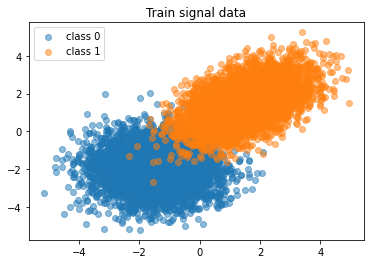

In [ ]:
plt.scatter(train_signal[0,:,0], train_signal[0,:,1], label="class 0", alpha=0.5)
plt.scatter(train_signal[1,:,0], train_signal[1,:,1], label="class 1", alpha=0.5)
plt.legend()
plt.title("Train signal data");

In [ ]:
# data marix with noise padding 

def generate_data(signal, noise, generate_Y=True):
  n = signal.shape[1]
  X = np.concatenate([signal, noise], axis=2) # concatenate 2-dimensional signal and 3-dimensional noise into 5-dimensional array
  X = np.concatenate(X, axis=0) # concatenate the separate arrays of each class (n rows each) to one array with 2n rows
  Y = np.hstack([np.zeros(n), np.ones(n)]).reshape(-1, 1) # create label indicating from which class (0 or 1) each data point is. Assumes ordered X array.
  if generate_Y:
    res = X, Y
  else:
    res = X
  return res

In [ ]:
train_X, train_Y =  generate_data(train_signal, train_noise)
test_X, test_Y =  generate_data(test_signal, test_noise)

#### Data representation

To apply the loss functions, we will need a representation function with some parameters $\theta$. <br>
We will use a neural network with a single two-dimensional layer, and consider it weights as $\theta$. <br>

Note that when using cross-entropy loss a single-layer neural network is simply a logistic regression (optimized via gradient descent). That is not the case anymore for the rest of the loss functions we implemented here.

In [ ]:
def init_representation(additional_layer_size=0):
    g = tf.keras.models.Sequential()
    g.add(tf.keras.layers.Dense(2))
    return g

To apply the representation function on a set of examples you can use

```
Xs_hat = g(Xs)
```



#### Training

In [ ]:
def sample_batch(X, Y, batch_size):
    N = len(X)
    batch_idx = np.random.choice(N, batch_size, replace=False)
    return tf.gather(X, batch_idx), tf.gather(Y, batch_idx)

In [ ]:
def train(train_X, train_Y, test_X, test_Y, itrs, loss_method, alpha=1.0, lr=0.01, batch_size=32, additional_layer_size=0, initialize=True, validate=True, pretrained_model=None):
  
  if initialize:
    # initialize representation
    g = init_representation(additional_layer_size)
  else:
    g = pretrained_model

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  for itr in tqdm(range(itrs)):
    
    batch_classes = 0
    # sample batch, ensuring to have at least 2 different classes
    while batch_classes < 2:
      batch_X, batch_Y = sample_batch(train_X, train_Y, batch_size)
      batch_classes = len(np.unique(batch_Y))

    with tf.GradientTape() as tape:
      # apply representation
      batch_X_hat = g(batch_X) 

      # compute loss
      loss = compute_loss(batch_X_hat, batch_Y, loss_method, alpha)
      theta = g.trainable_weights

    # optimization step
    grads = tape.gradient(loss, theta)
    optimizer.apply_gradients(zip(grads, theta))

    if itr % 25 == 0:
      print("iteration {}, train loss {:.3f}".format(itr, loss.numpy()))

    test_X_hat = None
    if validate:
      if itr == itrs -1:
        # evaluate loss on test set
        test_X_hat = g(test_X)
        test_loss = compute_loss(test_X_hat, test_Y, loss_method, alpha).numpy()
        print("iteration {}, train loss {:.3f}, test loss {:.3f}".format(itr, loss.numpy(), test_loss))

    if loss < -1e20:
      break
    
  return g, test_X_hat

## <font color='purple'> Using the "train" function we can compare results and representations leared by the different losses.  Try it out. You can also try changing the margin $\alpha$ and the data parameters.

For example, you can use


```
siamese_model, siamese_X_hat = train(train_X, train_Y, test_X, test_Y, itrs=500, loss_method="siamese", 
                                     alpha=1.0, lr=0.01, batch_size=32)
```

A good inndication that the model succeeds to learn is when the loss id reduced along the iterations. While you see a significant reduction, the model may benefit from adding iterations. You can continue the training from where you left off by using the flag 

```
initialize = False
```
and passing the model
```
pretrained_model = siamese_model
```

In [ ]:
### DELETE BELOW ###

Since our networks learn representations, and classification requires setting a distance in the representation space, to efficiently compare the methods we will use AUC instead.

For this we will consider a binary classification task of pairs, determining wether a pair of data-points is from the same class: we will create pairs of data-points from the same class (for these pairs the true label will be 1), and from different classes (their true label will be 0). We will use the negative distances in the representation space $- \Vert \hat{X}_i - \hat{X}_j \Vert^2$ as the classification scores.

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import combinations

In [ ]:
def select_pairs(X, Y, eval_n):
  all_pair_ids = combinations(range(len(X)), 2)
  all_pair_ids = np.array([p for p in all_pair_ids])
  eval_pairs = all_pair_ids[np.random.choice(range(len(all_pair_ids)), eval_n)]

  X1, Y1 = X[eval_pairs[:,0]], Y[eval_pairs[:,0]]
  X2, Y2 = X[eval_pairs[:,1]], Y[eval_pairs[:,1]]
  Y_ = (Y1==Y2)*1
  return X1, X2, Y_

In [ ]:
def AUC(X, Y, model, eval_n = 1000):

  # randomly select pairs
  X1, X2, Y_ = select_pairs(X, Y, eval_n)
  
  # compute distances in representation space
  dists = tf.reshape(square_norm(model(X1) - model(X2)), [-1,1]).numpy()

  fpr, tpr, thresholds = roc_curve(Y_.reshape(-1), -dists, pos_label=1)
  return auc(fpr, tpr)

Since our representation is 2-dimensional, we can easily plot both train and test examples in the learned representation space. 

In [ ]:
def plot_representation(X, Y, model, show_legend=True):
  X_hat = model(X).numpy()
  unq_Y = np.unique(Y)
  cs = [(Y.flatten() == y) for y in unq_Y]
  for i in range(len(unq_Y)):
    plt.scatter(X_hat[cs[i],0], X_hat[cs[i],1], label=i, alpha=0.5);
  if show_legend:
    plt.legend();

In [ ]:
def plot_distances(X, Y, model, eval_n = 1000, xlim=None, ylim=None):
  X_hat = model(X).numpy()
  X1, X2, Y_ = select_pairs(X_hat, Y, eval_n)
  pos_dists = square_norm(X1[Y_.flatten()==1] - X2[Y_.flatten()==1])
  neg_dists = square_norm(X1[Y_.flatten()==0] - X2[Y_.flatten()==0])

  plt.hist(pos_dists, color='C2', label='same class', alpha=0.5, density=True)
  plt.hist(neg_dists, color='C3', label='different classes', alpha=0.5, density=True)
  plt.legend()
  plt.title("Pairwise distances");
  if xlim is not None:
    plt.xlim(-1, xlim)
  if ylim is not None:
    plt.xlim(-1, ylim)

### Training a logistic regression

In [ ]:
logistic_model, logistic_X_hat = train(train_X, binary_to_onehot(train_Y), test_X, binary_to_onehot(test_Y), 500, "cross-entropy", alpha=1.0, lr = 0.01, batch_size=32)

  0%|          | 0/500 [00:00<?, ?it/s]

iteration 0, train loss 1.506
iteration 25, train loss 0.794
iteration 50, train loss 0.302
iteration 75, train loss 0.152
iteration 100, train loss 0.280
iteration 125, train loss 0.132
iteration 150, train loss 0.145
iteration 175, train loss 0.069
iteration 200, train loss 0.142
iteration 225, train loss 0.193
iteration 250, train loss 0.105
iteration 275, train loss 0.065
iteration 300, train loss 0.077
iteration 325, train loss 0.022
iteration 350, train loss 0.033
iteration 375, train loss 0.029
iteration 400, train loss 0.044
iteration 425, train loss 0.035
iteration 450, train loss 0.061
iteration 475, train loss 0.024
iteration 499, train loss 0.031, test loss 0.065


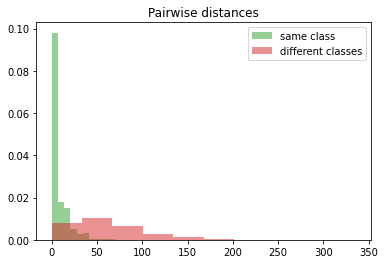

In [ ]:
plot_distances(test_X, test_Y, logistic_model)

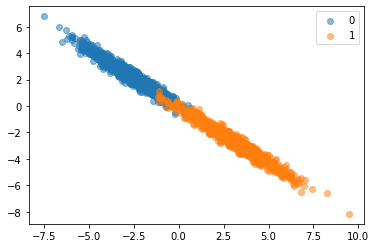

In [ ]:
logistic_plot = plot_representation(test_X, test_Y, logistic_model)

### Training a siamese neural network

In [ ]:
siamese_model, siamese_X_hat = train(train_X, train_Y, test_X, test_Y, 200, "siamese", alpha=1.0, lr = 0.01, batch_size=32)

  0%|          | 0/200 [00:00<?, ?it/s]

iteration 0, train loss 0.663
iteration 25, train loss 0.729
iteration 50, train loss 0.544
iteration 75, train loss 0.479
iteration 100, train loss 0.701
iteration 125, train loss 0.452
iteration 150, train loss 0.531
iteration 175, train loss 0.500
iteration 199, train loss 0.414, test loss 0.509


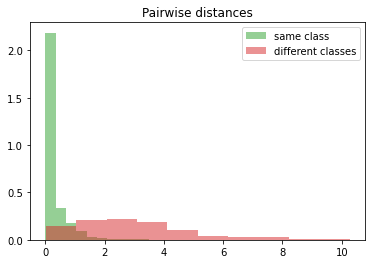

In [ ]:
plot_distances(test_X, test_Y, siamese_model)

In [ ]:
siamese_auc = AUC(test_X, test_Y, siamese_model)
siamese_auc

0.9610425975335112

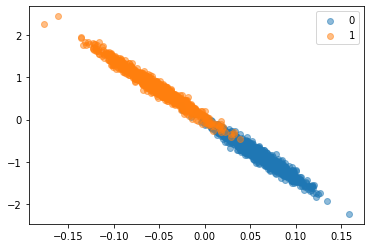

In [ ]:
siamese_plot = plot_representation(test_X, test_Y, siamese_model)

### Training a triplet neural network

In [ ]:
triplet_model, triplet_X_hat = train(train_X, train_Y, test_X, test_Y, 200, "triplet", alpha=1.0, lr = 1e-4, batch_size=32)

  0%|          | 0/200 [00:00<?, ?it/s]

iteration 0, train loss 0.588
iteration 25, train loss 0.302
iteration 50, train loss 0.253
iteration 75, train loss 0.465
iteration 100, train loss 0.265
iteration 125, train loss 0.488
iteration 150, train loss 0.090
iteration 175, train loss 0.492
iteration 199, train loss 0.209, test loss 0.347


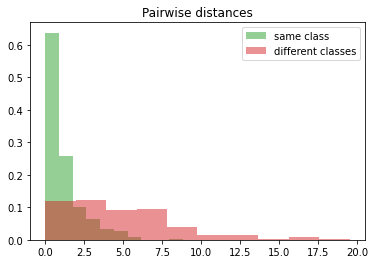

In [ ]:
plot_distances(test_X, test_Y, triplet_model)

In [ ]:
triplet_auc = AUC(test_X, test_Y, triplet_model)
triplet_auc

0.8736626305336666

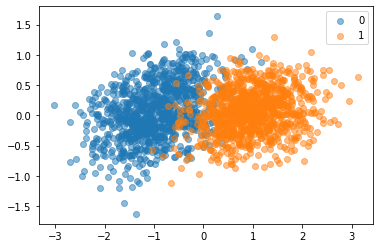

In [ ]:
triplet_plot = plot_representation(test_X, test_Y, triplet_model)

### Training a contrastive network

In [ ]:
contrastive_model, contrastive_X_hat = train(train_X, train_Y, test_X, test_Y, 200, "contrastive", alpha=1.0)

  0%|          | 0/200 [00:00<?, ?it/s]

iteration 0, train loss 0.299
iteration 25, train loss 0.192
iteration 50, train loss 0.115
iteration 75, train loss 0.082
iteration 100, train loss 0.123
iteration 125, train loss 0.024
iteration 150, train loss 0.033
iteration 175, train loss 0.044
iteration 199, train loss 0.058, test loss 0.061


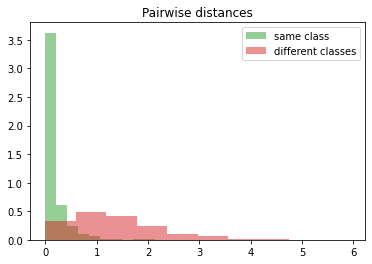

In [ ]:
plot_distances(test_X, test_Y, contrastive_model)

In [ ]:
contrastive_auc = AUC(test_X, test_Y, contrastive_model)
contrastive_auc

0.9642914318647541

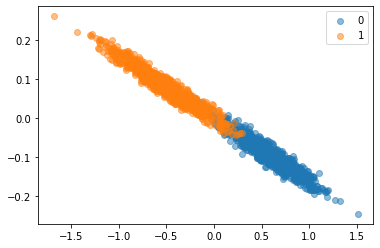

In [ ]:
contrastive_plot = plot_representation(test_X, test_Y, contrastive_model)

In [ ]:
### END DELETE ###

This is a  simple  binary classification task, and therefore all the models should perform relatively welll. Now we will to a setting with more classes, and only a few training examples for each class.

### 1.2 Multi-class classification with few examples


For this part we will continue using 5-dimensional vectors, where the first two dimensions (signal) will be sampled from 2-dimensional Normal distributions:
$\mathcal{N}\left(\mu_{j},\Sigma_j\right), \; 1 \leq j \leq K $ where $\mu_j\in \mathbb{R}^2$ and $\Sigma_j \in \mathbb{R}^{2 \times 2}$.<br>
As before, The additional 3 dimensions will include noise sampled from the same distribution for all classes. <br>

However, this time we will use K different classes and generate the corresponding distributions $\mathcal{N}\left(\mu_{j},\Sigma_j\right)$ randomly. <br>
We will sample the means $\mu_j$ from a Normal bi-variate distribution $\mathcal{N}\left(0,kI\right)$. <br>
For the covariance matricies we will generate matricies $A_j$ with uniform values $U(0,1)$. To get symmetric positive-semidefinite matrices we will set $\Sigma_j = A_j^TA_j.$



In [ ]:
k = 50 # number of classes
n = 5 # number of data points in each class in train_set
n_test = 5 # number of data points in each class in test
N = n*k # total number of data points in train

In [ ]:
# sample expectations from bi-variate normal distribution
mus = np.random.multivariate_normal(np.zeros(2), k*np.eye(2), size=k)

# sample 2x2 matricies with values sampled from U(0,1)
A_matricies = np.random.rand(k, 2, 2)
# quadratic form to transform each A matrix to a symmetric positive-semidefinite matrix
sigmas = np.array([np.dot(A, A.transpose()) for A in A_matricies])

In [ ]:
# sample signal and noise from respective gaussian distributions
train_signal = np.array([np.random.multivariate_normal(mus[i], sigmas[i], size=n) for i in range(k)])
train_noise = np.array([np.random.multivariate_normal(noise_mu, noise_sigma, size=n) for i in range(k)])

test_signal = np.array([np.random.multivariate_normal(mus[i], sigmas[i], size=n_test) for i in range(k)])
test_noise = np.array([np.random.multivariate_normal(noise_mu, noise_sigma, size=n_test) for i in range(k)])

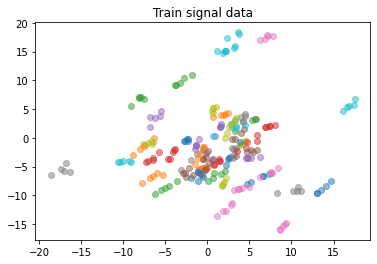

In [ ]:
# plot train signal data
for i in range(k):
  plt.scatter(train_signal[i,:,0], train_signal[i,:,1], alpha=0.5)
plt.title("Train signal data");

In [ ]:
train_X =  generate_data(train_signal, train_noise, generate_Y=False)
train_Y = np.stack([np.ones(n)*i for i in range(k)]).reshape(n*k,1)

test_X =  generate_data(test_signal, test_noise, generate_Y=False)
test_Y = np.stack([np.ones(n_test)*i for i in range(k)]).reshape(n*k,1)

In [ ]:
def multi_to_onehot(Y):
  Y = Y.flatten().astype(int)
  onehot = np.zeros((Y.size, Y.max() + 1))
  onehot[np.arange(Y.size), Y] = 1
  return onehot

In [ ]:
oh_train_Y, oh_test_Y = multi_to_onehot(train_Y), multi_to_onehot(test_Y)

In the binary setting to get a logistic regression we could apply the cross-entropy loss directly on the 2-dimensional representation. The multi-class setting requires the model's output to be in the same dimension as the number of classes. Therefore, we need to add another layer of size $k$. However, training a larger model would make the comparison to other models more difficult, and therefore we set the weights of the additional layer to non-trainable. That is, as in the other methods, only the 2-dimensional representation is trained.

In [ ]:
def init_representation(additional_layer_size=0):
  layer = tf.keras.layers.Dense(2)
  if additional_layer_size==0:
    g = tf.keras.Sequential([layer])
  else: 
    frozen_layer = tf.keras.layers.Dense(additional_layer_size)
    frozen_layer.trainable = False
    g = tf.keras.Sequential([layer, frozen_layer])
  return g

In [ ]:
logistic_model, logistic_X_hat = train(train_X, oh_train_Y, test_X, oh_test_Y, 300, "cross-entropy", alpha=1.0, lr = 0.01, batch_size=32, additional_layer_size=k)

  0%|          | 0/300 [00:00<?, ?it/s]

iteration 0, train loss 5.224
iteration 25, train loss 4.157
iteration 50, train loss 4.010
iteration 75, train loss 3.988
iteration 100, train loss 3.935
iteration 125, train loss 3.906
iteration 150, train loss 3.762
iteration 175, train loss 3.639
iteration 200, train loss 3.681
iteration 225, train loss 3.911
iteration 250, train loss 3.856
iteration 275, train loss 3.786
iteration 299, train loss 3.786, test loss 3.832


To compute the 2-dimensional representation (instead of the output of the additional layer for the logistic regression) we extract layer outputs

In [ ]:
def logistic_representation(X):
  return logistic_model.layers[0](X)

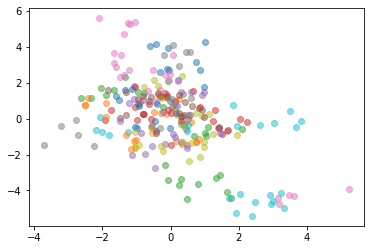

In [ ]:
plot_representation(test_X, test_Y, logistic_representation, show_legend=False)

In [ ]:
true_label = tf.cast(tf.reshape(test_Y, -1), tf.int64)

Y_hat = tf.nn.softmax(logistic_model(test_X))
predicted_label = tf.math.argmax(Y_hat, axis=1)

accuracy = np.mean(true_label.numpy() == predicted_label.numpy())
accuracy

0.04

As you can see, the logistic model now fails. 

## <font color='purple'> Try out few-shot losses and see how they do


In [ ]:
### DELETE BELOW ###

In [ ]:
siamese_model, siamese_X_hat = train(train_X, train_Y, test_X, test_Y, 200, "siamese", alpha=1.0, lr = 0.01, batch_size=64)

  0%|          | 0/200 [00:00<?, ?it/s]

iteration 0, train loss 1.347
iteration 25, train loss 0.510
iteration 50, train loss 0.465
iteration 75, train loss 0.517
iteration 100, train loss 0.416
iteration 125, train loss 0.367
iteration 150, train loss 0.381
iteration 175, train loss 0.402
iteration 199, train loss 0.407, test loss 0.403


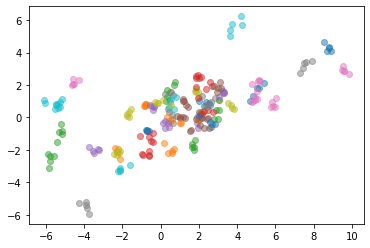

In [ ]:
plot_representation(test_X, test_Y, siamese_model, show_legend=False)

In [ ]:
siamese_auc = AUC(test_X, test_Y, siamese_model)
siamese_auc

0.9876122862938279

In [ ]:
triplet_model, triplet_X_hat = train(train_X, train_Y, test_X, test_Y, 100, "triplet", alpha=1.0, lr = 0.01, batch_size=32)

  0%|          | 0/100 [00:00<?, ?it/s]

iteration 0, train loss 0.000
iteration 25, train loss 0.000
iteration 50, train loss 0.000
iteration 75, train loss 0.000
iteration 99, train loss 0.000, test loss 0.065


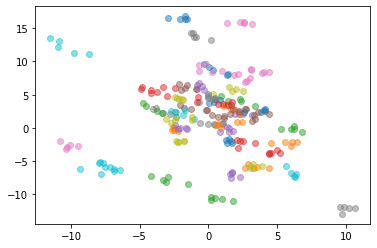

In [ ]:
plot_representation(test_X, test_Y, triplet_model, show_legend=False)

In [ ]:
triplet_auc = AUC(test_X, test_Y, triplet_model)
triplet_auc

0.9884263959390862

In [ ]:
contrastive_model, contrastive_X_hat = train(train_X, train_Y, test_X, test_Y, 200, "contrastive", alpha=1.0, lr = 0.01, batch_size=32)

  0%|          | 0/100 [00:00<?, ?it/s]

iteration 0, train loss 0.006
iteration 25, train loss 0.001
iteration 50, train loss 0.013
iteration 75, train loss 0.082
iteration 99, train loss 0.024, test loss 0.041


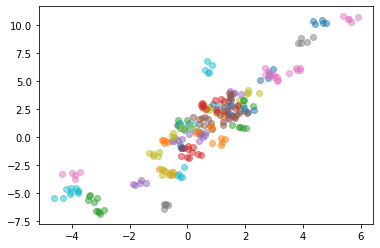

In [ ]:
plot_representation(test_X, test_Y, contrastive_model, show_legend=False)

In [ ]:
contrastive_auc = AUC(test_X, test_Y, contrastive_model)
contrastive_auc

0.9843117408906882

In [ ]:
### END DELETE ###

## 2 Few-shot learning on real data 

Now we will move on to a few-shot scenario of character classification. <br> 
We will work on the Omniglot dataset, that includes 1623 characters (classes) from 50 different alphabets.<br>
In the original data division none of the 659 characters from the test appears in the train set.


In [ ]:
train_data = tfds.load("omniglot", as_supervised=True, split="train")
test_data = tfds.load("omniglot", as_supervised=True, split="test")

In [ ]:
def extraction(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    return image, label

In [ ]:
def get_data(data_set):
    images = []
    labels = []
    for image, label in tqdm(data_set.map(extraction)):
        image = image.numpy()
        label = str(label.numpy())
        images.append(image)
        labels.append(label)   
    images = np.array(images)
    labels = np.array(labels).astype('int')
    return images, labels

In [ ]:
x_train, y_train = get_data(train_data)
x_test, y_test = get_data(test_data)

  0%|          | 0/19280 [00:00<?, ?it/s]

  0%|          | 0/13180 [00:00<?, ?it/s]

In [ ]:
# unique classes in train and test
unq_y_train = np.unique(y_train)
unq_y_test = np.unique(y_test)

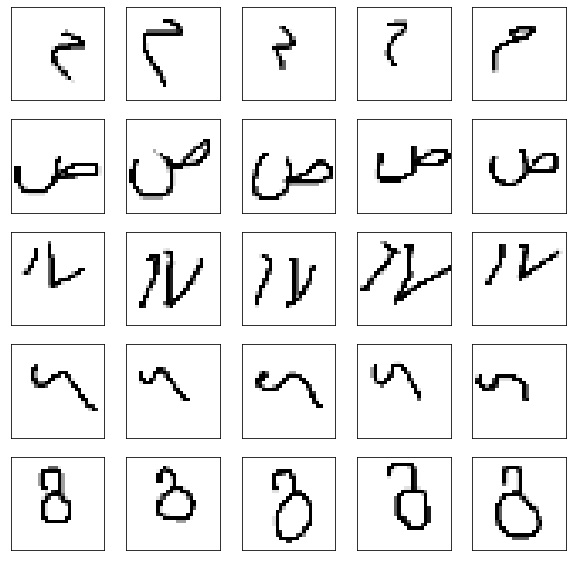

In [ ]:
# visualize some examples
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, cls in enumerate(np.random.choice(unq_y_train, size=5)):
    for j in range(5):
        temp_image = x_train[y_train==cls][j].reshape(28, 28)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        axs[i,j].imshow(temp_image, cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False);

We will practice a 5-way 1-shot scenario. That is, we will have:


*   Training set - 20 images for each of the 964 "old" classes
*   Support set - 1 image for each of 5 "new" classes
*   Qery set - 19 images for each of 5 "new" classes

We will begin by training a representation over the training set, and later on will fine-tune it on the additional examples. <br>

For this data we will need a more complex representation. We will use a relatively shallow convolutional neural network.

In [ ]:
def init_representation(additional_layer_size=0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(28, 28, 1)))
    # round 1
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    # round 2
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    # round 3
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  
    return model

We begin by training a model on the whole training set. We will arbitrarily use here triplet networks.


In [ ]:
omng_triplet_model, omng_triplet_X_hat = train(x_train, y_train, None, None, 100, "triplet", alpha=1.0, lr = 0.01, batch_size=64, validate=False)

  0%|          | 0/100 [00:00<?, ?it/s]

iteration 0, train loss 0.990
iteration 25, train loss 0.000
iteration 50, train loss 0.092
iteration 75, train loss 0.000


Now we will fine-tune this model on the support set. For this we will first freeze all the network layers, except the last one. 


In [ ]:
for layer in omng_triplet_model.layers[:-1]:
  layer.trainable = False

In [ ]:
n_classes = 5

For evaluation we will train multiple times, each time sampling a different set of 5 classes.

In [ ]:
repeat = 10

classes = []
models = []
query_xs = []
query_ys = []

for i in range(repeat):

  # sample 5 test classes
  few_classes = y_test[np.random.choice(len(unq_y_test), 5, replace=False)]

  support_x = []
  support_y = []
  query_x = []
  query_y = []

  for y in few_classes:
    # indices of x values from the chosen classes
    idx = np.where(y_test==y)[0]

    # choose one of the for support
    t = np.random.choice(n_classes, 1)
    support_x.append(x_test[idx[t]])
    support_y.append(y)

    # set the rest to query
    query_idx = [v for v in idx if v!=idx[t]]
    query_n = len(query_idx)
    query_x.append(x_test[query_idx])
    query_y.append(np.repeat(y, query_n))

  # lists to numpy arrays  
  support_x = np.array(support_x).reshape(n_classes, 28, 28, 1)
  support_y = np.array(support_y)
  query_x = np.array(query_x).reshape(n_classes*query_n, 28, 28, 1)
  query_y = np.array(query_y).reshape(-1)

  model, _ = train(support_x, support_y, None, None, 50, "triplet", alpha=1.0, lr = 0.01, batch_size=n_classes, validate=False, pretrained_model=omng_triplet_model)

  classes.append(few_classes)
  models.append(model)
  query_xs.append(query_x)
  query_ys.append(query_y)

  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.983
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.983
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.980
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.988
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.985
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.992
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.972
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.974
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.983
iteration 25, train loss 0.000


  0%|          | 0/50 [00:00<?, ?it/s]

iteration 0, train loss 0.988
iteration 25, train loss 0.000


## <font color='purple'> Analyze the results


You can get the classes model, and test X and Y values of the i-th repetition by: 

```
classes[i], models[i], query_xs[i], query_ys[i]
```




In [ ]:
### DELETE BELOW ###

In [ ]:
few_AUCs = {}
for i in range(repeat):
  model, xs, ys = models[i], query_xs[i], query_ys[i]
  few_AUCs[i] = AUC(xs, ys, model)

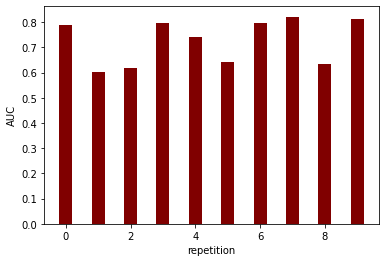

In [ ]:
keys = list(few_AUCs.keys())
values = list(few_AUCs.values())

plt.bar(keys, values, color ='maroon', width = 0.4)
plt.ylabel("AUC")
plt.xlabel("repetition");

Now our representation is of dimension 64. To plot it in two dimensions we will use a UMAP dimension reduction, which has good preservation of the global structure

In [ ]:
! pip uninstall umap

In [ ]:
! pip install umap-learn

In [ ]:
import umap.umap_ as umap

In [ ]:
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)

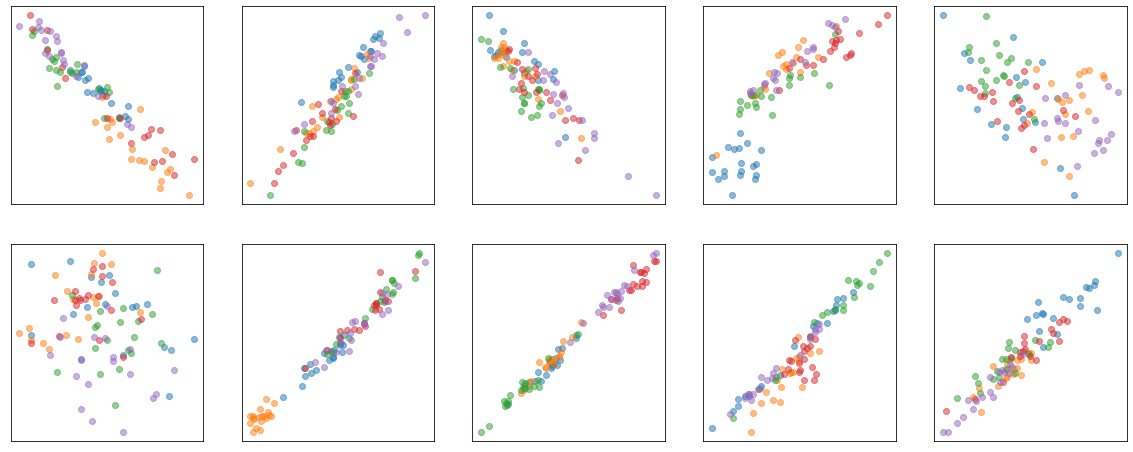

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

i, j = 0, 0 

for m in range(10):
  
  i = m//5
  j = m%5

  # extract trained model and corresponding query data
  model, xs, ys = models[m], query_xs[m], query_ys[m]
  # representation
  xs_hat = model(xs).numpy()
  # UMAP projection
  xs_proj = umap_2d.fit_transform(xs_hat)

  # plot
  unq_Y = np.unique(ys)
  cs = [(ys.flatten() == y) for y in unq_Y]
  for a in range(len(unq_Y)):
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].scatter(xs_hat[cs[a],0], xs_hat[cs[a],1], label=a, alpha=0.5);